# Data Mining Project 
Ahmed - F2300082

Duha - A01193

Sayera - F2300198

In [163]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import json
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

# Set style for better-looking plots
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)

In [164]:
# Load all datasets
transactions = pd.read_csv('Input/transactions_2019data.csv')
cards = pd.read_csv('Input/cards_data.csv')
users = pd.read_csv('Input/users_data.csv')

# Load fraud labels
with open('Input/fraud_labels.json', 'r') as f:
    fraud_labels = json.load(f)

# Convert fraud labels to DataFrame for easier merging
fraud_df = pd.DataFrame(fraud_labels)
fraud_df.rename(columns={'fraud': 'is_fraud'}, inplace=True)
fraud_df['is_fraud'] = fraud_df['is_fraud'].map({'Yes': 1, 'No': 0})

print("Data loaded successfully!")
print(f"Transactions shape: {transactions.shape}")
print(f"Cards shape: {cards.shape}")
print(f"Users shape: {users.shape}")
print(f"Fraud labels shape: {fraud_df.shape}")

Data loaded successfully!
Transactions shape: (1159966, 12)
Cards shape: (6146, 13)
Users shape: (2000, 14)
Fraud labels shape: (777339, 2)


# Part 1: Exploratory Data Analysis (EDA)

## Objective
Understand the dataset and identify initial patterns or anomalies.


## 1. Data Overview

### 1.1 Dataset Description

This section describes the dataset structure: number of rows, columns, types of variables, and memory usage.



Transactions:
  Rows: 1,159,966
  Columns: 12
  Memory usage: 415.04 MB

  Column names and types:
id                  int64
date               object
client_id           int64
card_id             int64
amount             object
use_chip           object
merchant_id         int64
merchant_city      object
merchant_state     object
zip               float64
mcc                 int64
errors             object
dtype: object


Transactions - Missing Values:
  Total columns with missing values: 3
  Total missing values: 1,433,315

  Missing values by column:
    merchant_state: 141,071 (12.16%)
    zip: 150,932 (13.01%)
    errors: 1,141,312 (98.39%)



Cards:
  Rows: 6,146
  Columns: 13
  Memory usage: 2.51 MB

  Column names and types:
id                        int64
client_id                 int64
card_brand               object
card_type                object
card_number               int64
expires                  object
cvv                       int64
has_chip                 object
num_cards_issued          int64
credit_limit             object
acct_open_date           object
year_pin_last_changed     int64
card_on_dark_web         object
dtype: object


Cards - Missing Values:
  No missing values



Users:
  Rows: 2,000
  Columns: 14
  Memory usage: 0.68 MB

  Column names and types:
id                     int64
current_age            int64
retirement_age         int64
birth_year             int64
birth_month            int64
gender                object
address               object
latitude             float64
longitude            float64
per_capita_income     object
yearly_income         object
total_debt            object
credit_score           int64
num_credit_cards       int64
dtype: object


Users - Missing Values:
  No missing values



Fraud Labels:
  Rows: 777,339
  Columns: 2
  Memory usage: 11.86 MB

  Column names and types:
transaction_id    int64
is_fraud          int64
dtype: object


Fraud Labels - Missing Values:
  No missing values


### 1.2 Descriptive Statistics

Transactions - Numerical Summary:
                 id     client_id       card_id   merchant_id           zip  \
count  1.159966e+06  1.159966e+06  1.159966e+06  1.159966e+06  1.009034e+06   
mean   2.304471e+07  1.027120e+03  3.481924e+03  4.763834e+04  5.139910e+04   
std    4.143772e+05  5.808680e+02  1.674779e+03  2.583664e+04  2.944576e+04   
min    2.232646e+07  0.000000e+00  0.000000e+00  2.000000e+00  1.001000e+03   
25%    2.268609e+07  5.250000e+02  2.405000e+03  2.578100e+04  2.858600e+04   
50%    2.304509e+07  1.070000e+03  3.602000e+03  4.564200e+04  4.802100e+04   
75%    2.340356e+07  1.531000e+03  4.886000e+03  6.770600e+04  7.815500e+04   
max    2.376187e+07  1.998000e+03  6.144000e+03  1.003400e+05  9.982900e+04   

                mcc  
count  1.159966e+06  
mean   5.564640e+03  
std    8.785077e+02  
min    1.711000e+03  
25%    5.300000e+03  
50%    5.499000e+03  
75%    5.812000e+03  
max    9.402000e+03  


Transactions - Categorical Summary:

date:
date
2019-05-24 10:21:00    16
2019-10-28 09:17:00    15
2019-07-08 08:42:00    15
2019-03-21 11:05:00    15
2019-03-21 12:49:00    15
2019-09-19 11:08:00    15
2019-05-18 10:58:00    15
2019-04-22 12:58:00    15
2019-03-21 07:49:00    14
2019-08-09 09:57:00    14
Name: count, dtype: int64

amount:
amount
$80.00     11281
$100.00    11059
$60.00      8660
$120.00     6921
$40.00      4900
$140.00     3888
$20.00      2430
$160.00     1901
$51.00      1125
$57.00      1083
Name: count, dtype: int64

use_chip:
use_chip
Chip Transaction      823180
Swipe Transaction     196799
Online Transaction    139987
Name: count, dtype: int64

merchant_city:
merchant_city
ONLINE          141071
Houston          12324
Brooklyn          7342
Miami             7298
Los Angeles       6759
Chicago           6407
Dallas            6289
Philadelphia      5626
Louisville        5601
San Antonio       5141
Name: count, dtype: int64

merchant_state:
merchant_state
CA 

Cards - Numerical Summary:
                id    client_id   card_number          cvv  num_cards_issued  \
count  6146.000000  6146.000000  6.146000e+03  6146.000000       6146.000000   
mean   3072.500000   994.939636  4.820426e+15   506.220794          1.503091   
std    1774.341709   578.614626  1.328582e+15   289.431123          0.519191   
min       0.000000     0.000000  3.001055e+14     0.000000          1.000000   
25%    1536.250000   492.250000  4.486365e+15   257.000000          1.000000   
50%    3072.500000   992.000000  5.108957e+15   516.500000          1.000000   
75%    4608.750000  1495.000000  5.585237e+15   756.000000          2.000000   
max    6145.000000  1999.000000  6.997197e+15   999.000000          3.000000   

       year_pin_last_changed  
count            6146.000000  
mean             2013.436707  
std                 4.270699  
min              2002.000000  
25%              2010.000000  
50%              2013.000000  
75%              2017.000000  
max 

Cards - Categorical Summary:

card_brand:
card_brand
Mastercard    3209
Visa          2326
Amex           402
Discover       209
Name: count, dtype: int64

card_type:
card_type
Debit              3511
Credit             2057
Debit (Prepaid)     578
Name: count, dtype: int64

expires:
expires
02/2020    377
01/2020    130
01/2021     93
03/2024     93
10/2024     93
          ... 
06/2001      1
05/2005      1
02/2007      1
05/2002      1
05/2006      1
Name: count, Length: 259, dtype: int64

has_chip:
has_chip
YES    5500
NO      646
Name: count, dtype: int64

credit_limit:
credit_limit
$0         31
$8700      25
$8000      25
$9300      24
$10600     24
           ..
$132439     1
$125723     1
$34900      1
$23344      1
$21968      1
Name: count, Length: 3654, dtype: int64

acct_open_date:
acct_open_date
02/2020    607
01/2020    571
02/2010     65
09/2009     51
09/2010     50
          ... 
09/1993      1
08/1995      1
11/1995      1
09/1997      1
07/1991      1
Name: count, L

Users - Numerical Summary:
                id  current_age  retirement_age   birth_year  birth_month  \
count  2000.000000  2000.000000     2000.000000  2000.000000  2000.000000   
mean    999.500000    45.391500       66.237500  1973.803000     6.439000   
std     577.494589    18.414092        3.628867    18.421234     3.565338   
min       0.000000    18.000000       50.000000  1918.000000     1.000000   
25%     499.750000    30.000000       65.000000  1961.000000     3.000000   
50%     999.500000    44.000000       66.000000  1975.000000     7.000000   
75%    1499.250000    58.000000       68.000000  1989.000000    10.000000   
max    1999.000000   101.000000       79.000000  2002.000000    12.000000   

          latitude    longitude  credit_score  num_credit_cards  
count  2000.000000  2000.000000   2000.000000       2000.000000  
mean     37.389225   -91.554765    709.734500          3.073000  
std       5.114324    16.283293     67.221949          1.637379  
min      20.880

Users - Categorical Summary:

gender:
gender
Female    1016
Male       984
Name: count, dtype: int64

address:
address
506 Washington Lane         2
766 Third Drive             1
3 Madison Street            1
9620 Valley Stream Drive    1
58 Birch Lane               1
5695 Fifth Street           1
1941 Ninth Street           1
11 Spruce Avenue            1
887 Grant Street            1
888 Fifth Lane              1
Name: count, dtype: int64

per_capita_income:
per_capita_income
$0        15
$19382     4
$21869     3
$22599     3
$15385     3
$13739     3
$13002     3
$15955     3
$40364     3
$32580     3
Name: count, dtype: int64

yearly_income:
yearly_income
$44128    3
$41483    2
$41141    2
$28553    2
$82298    2
$49967    2
$63355    2
$66489    2
$69412    2
$38609    2
Name: count, dtype: int64

total_debt:
total_debt
$0         102
$107734      2
$50190       2
$35268       2
$23909       2
$48624       2
$66044       2
$21853       2
$51428       2
$12777       2
Name: count

### 1.3 Initial Visualizations


Amount column converted to numeric
Merged dataset shape: (1159966, 15)


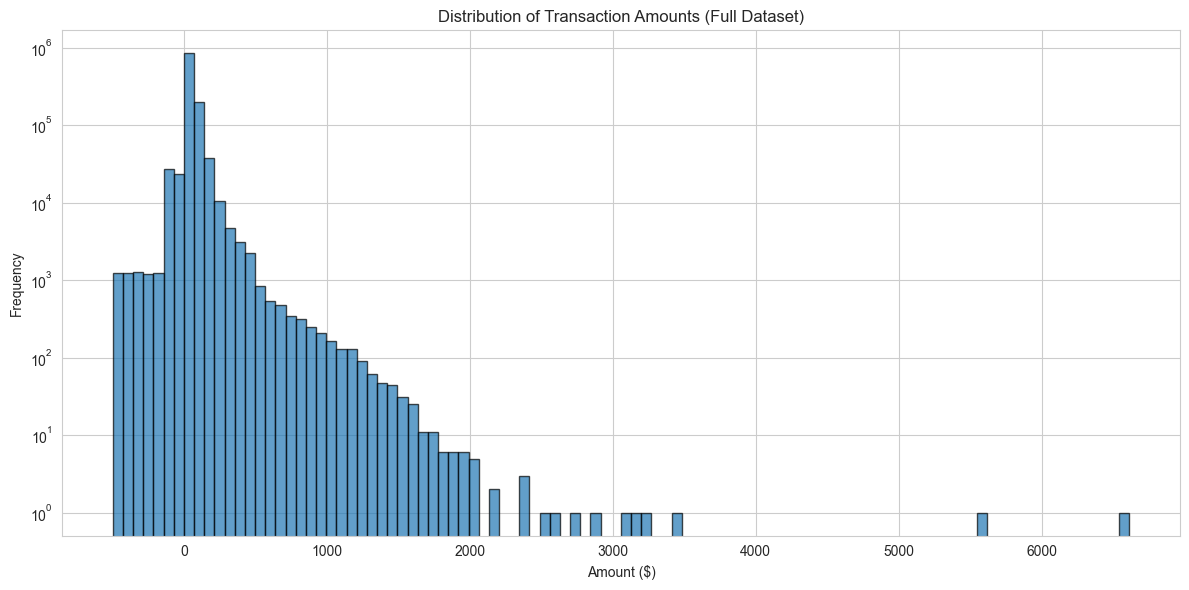

Total transactions: 1,159,966
Mean amount: $42.65
Median amount: $28.86
Std deviation: $80.59


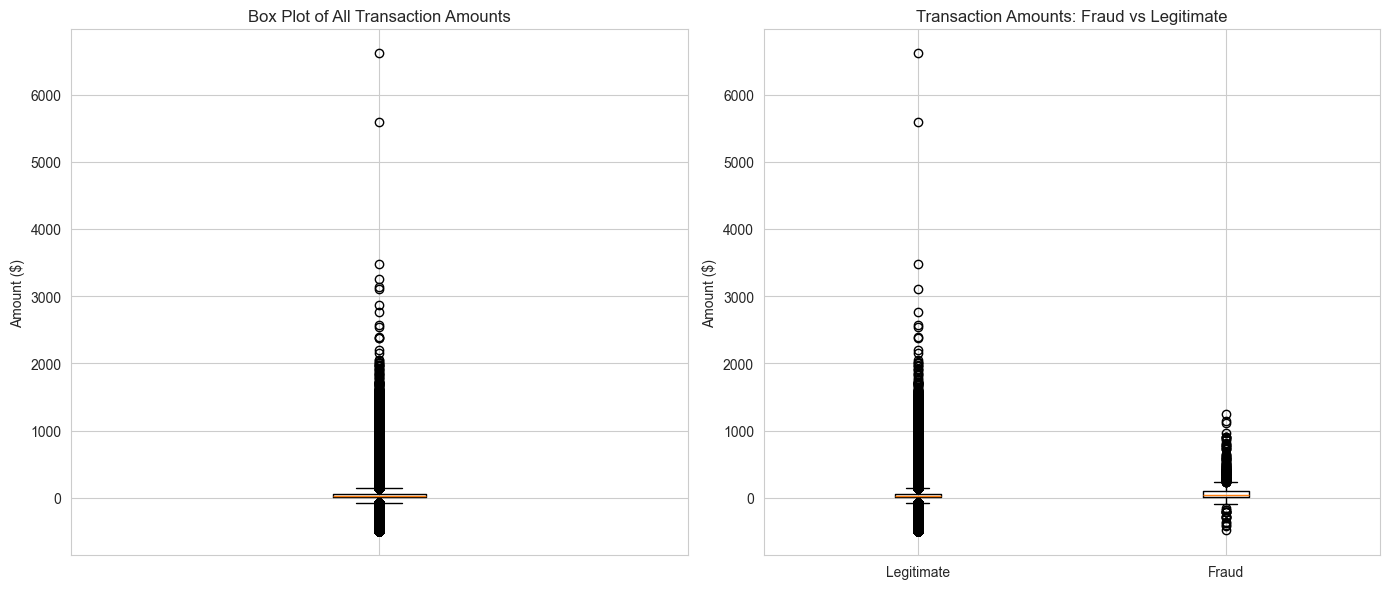


Legitimate transactions: 775,979
  Mean: $42.60, Median: $28.80

Fraudulent transactions: 1,360
  Mean: $85.59, Median: $37.47


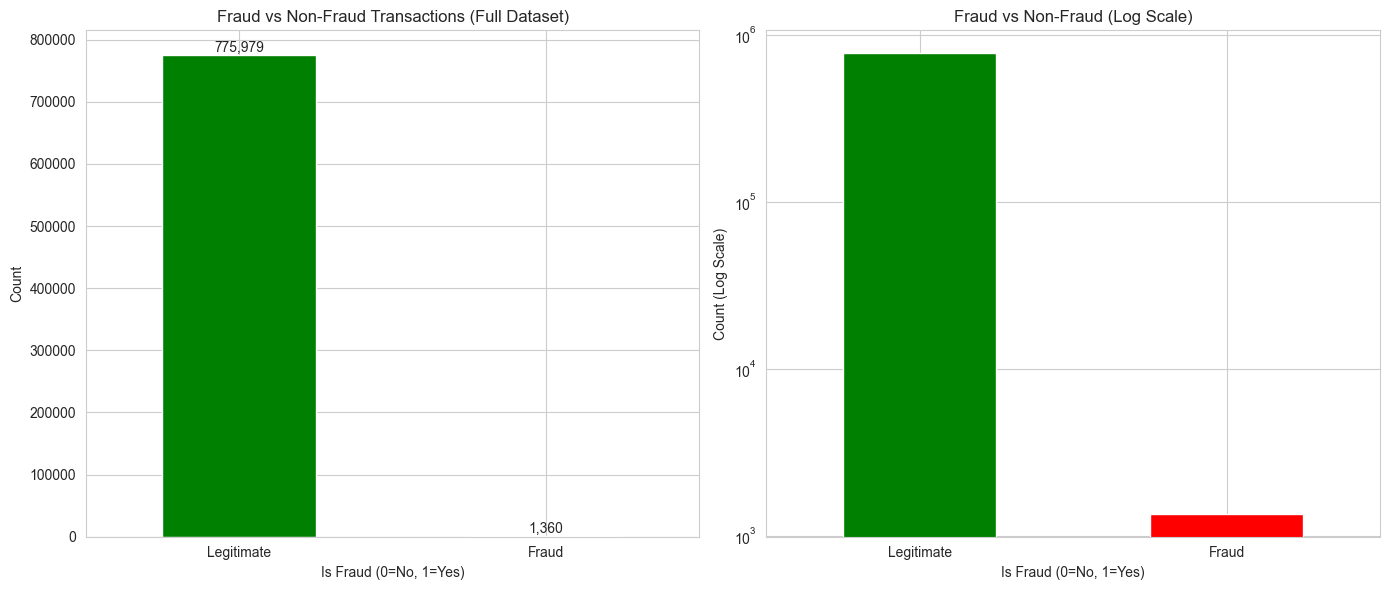


Total transactions: 1,159,966
Legitimate: 775,979 (66.90%)
Fraudulent: 1,360 (0.12%)


In [182]:
# Fraud Distribution - Count Plot (Full Dataset)
if 'is_fraud' in df_merged.columns:
    fraud_counts = df_merged['is_fraud'].value_counts().sort_index()
    
    fig, axes = plt.subplots(1, 2, figsize=(14, 6))
    
    # Bar chart with actual counts
    fraud_counts.plot(kind='bar', ax=axes[0], color=['green', 'red'])
    axes[0].set_title('Fraud vs Non-Fraud Transactions (Full Dataset)')
    axes[0].set_xlabel('Is Fraud (0=No, 1=Yes)')
    axes[0].set_ylabel('Count')
    axes[0].set_xticklabels(['Legitimate', 'Fraud'], rotation=0)
    axes[0].tick_params(axis='y', labelsize=10)
    
    # Add count labels on bars
    for i, v in enumerate(fraud_counts):
        axes[0].text(i, v, f'{v:,}', ha='center', va='bottom', fontsize=10)
    
    # Bar chart with log scale to better see fraud cases
    fraud_counts.plot(kind='bar', ax=axes[1], color=['green', 'red'])
    axes[1].set_title('Fraud vs Non-Fraud (Log Scale)')
    axes[1].set_xlabel('Is Fraud (0=No, 1=Yes)')
    axes[1].set_ylabel('Count (Log Scale)')
    axes[1].set_xticklabels(['Legitimate', 'Fraud'], rotation=0)
    axes[1].set_yscale('log')
    
    plt.tight_layout()
    plt.show()
    
    # Print detailed statistics
    total = len(df_merged)
    fraud_total = fraud_counts.get(1, 0)
    legit_total = fraud_counts.get(0, 0)
    print(f"\nTotal transactions: {total:,}")
    print(f"Legitimate: {legit_total:,} ({legit_total/total*100:.2f}%)")
    print(f"Fraudulent: {fraud_total:,} ({fraud_total/total*100:.2f}%)")


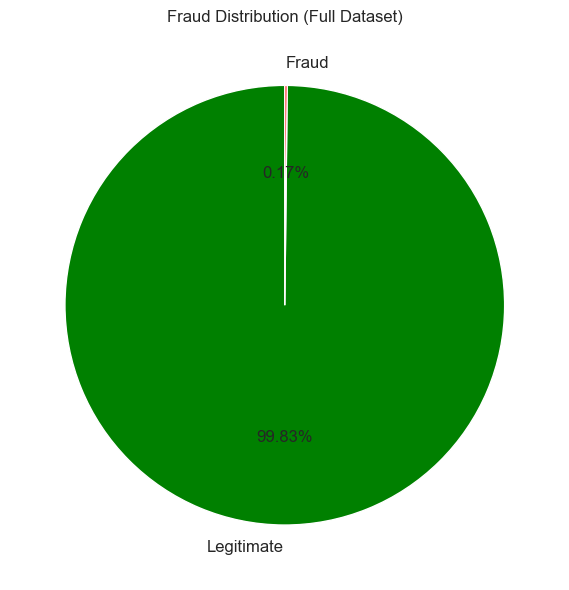


Fraud Rate: 0.1750%
This is a low imbalanced dataset


✓ Merged transactions with cards data (using 'id' as merge key)
  df_with_cards shape: (1159966, 19)


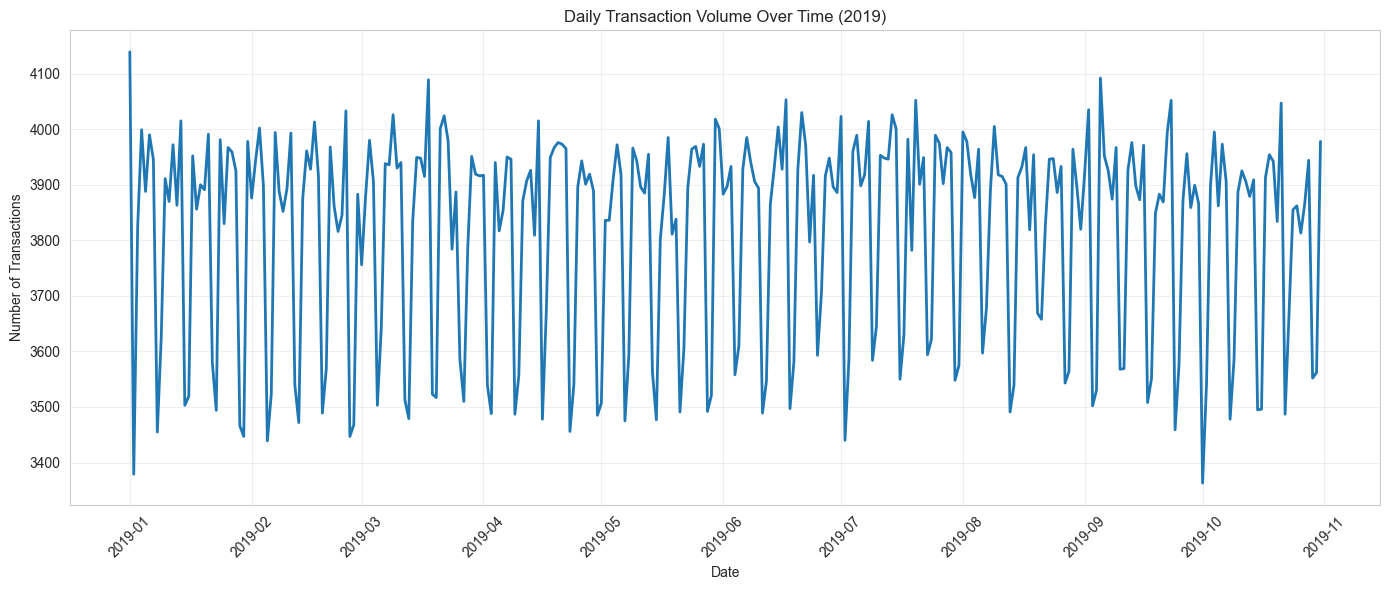

Date range: 2019-01-01 00:02:00 to 2019-10-31 23:59:00


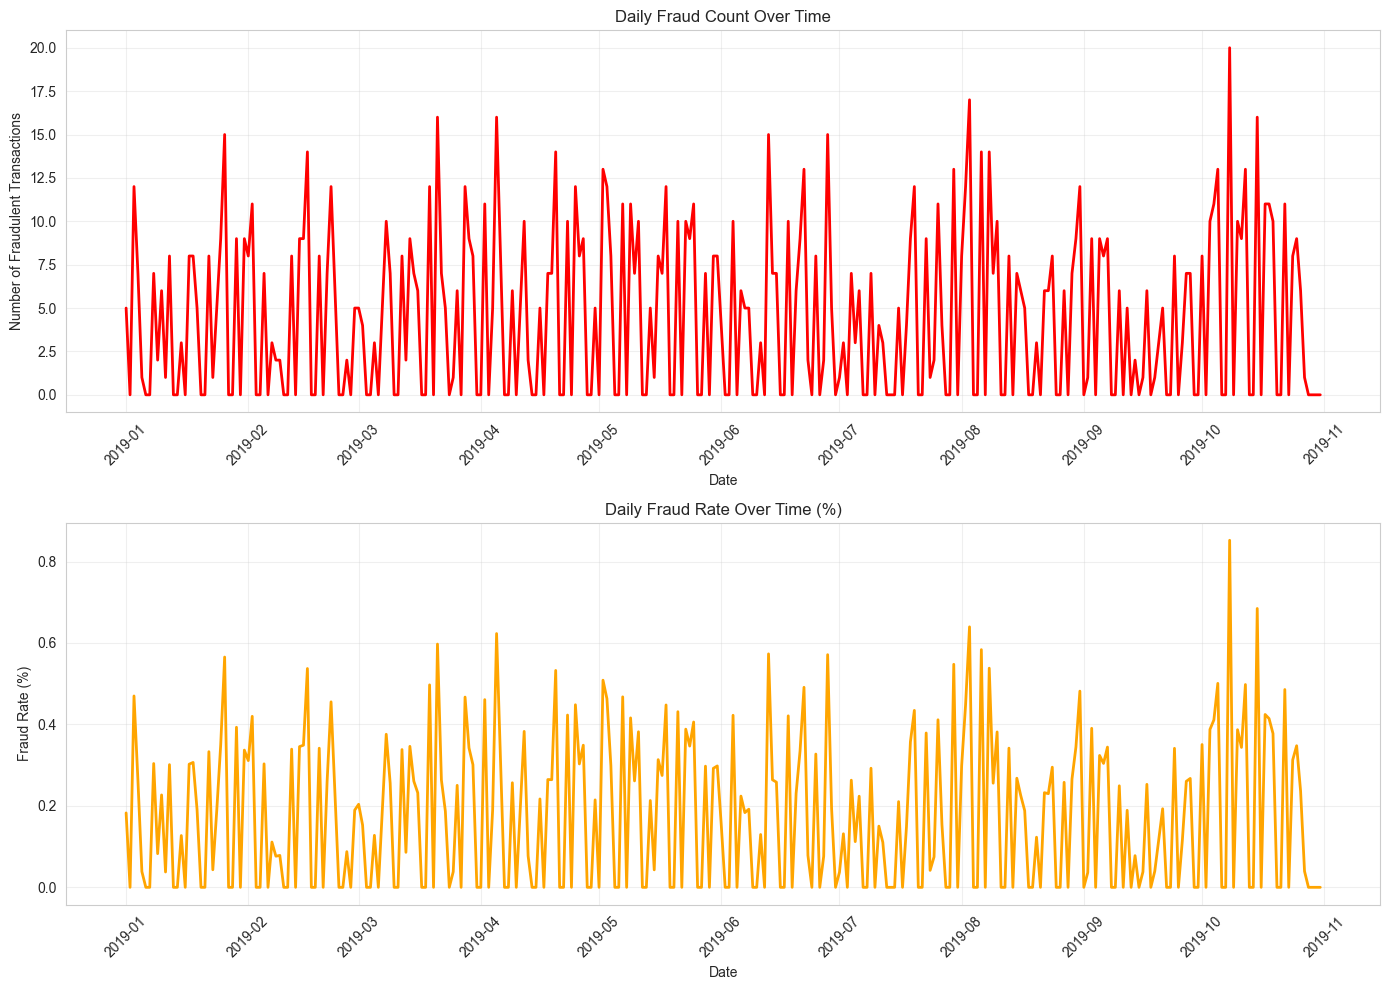

Average daily fraud rate: 0.1751%
Max daily fraud rate: 0.8522%
Min daily fraud rate: 0.0000%


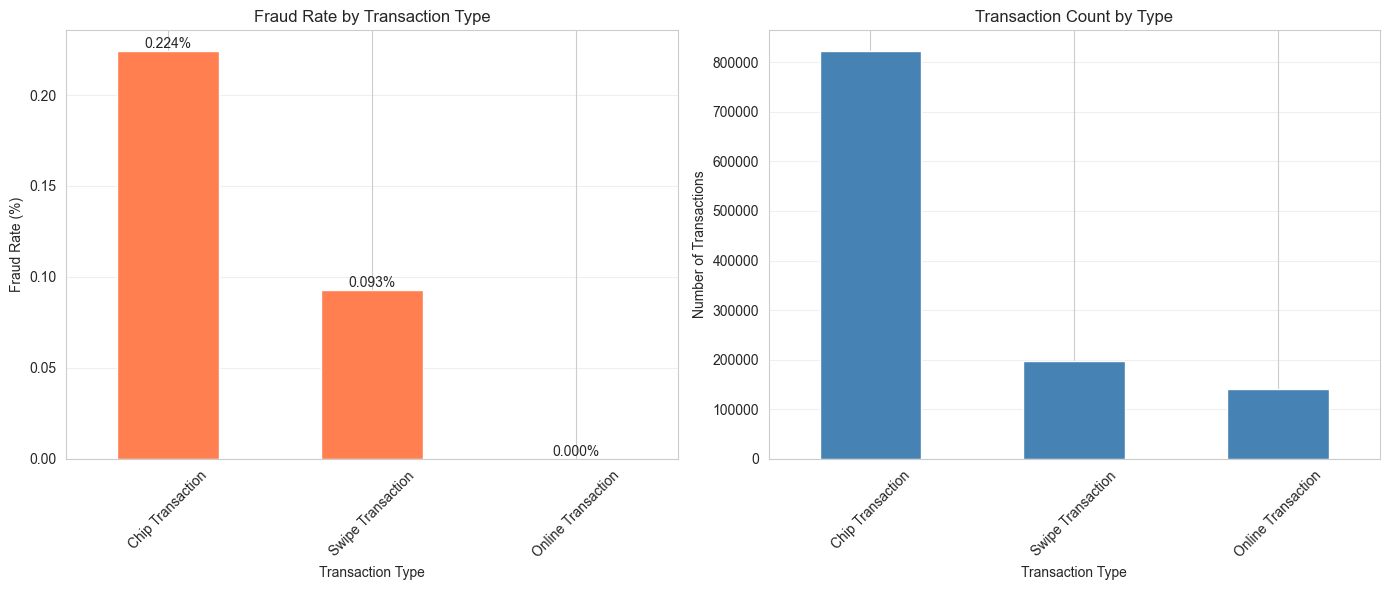


Fraud Rate by Transaction Type:
                     count     sum  fraud_rate
use_chip                                      
Chip Transaction    551905  1238.0    0.224314
Swipe Transaction   131632   122.0    0.092683
Online Transaction   93802     0.0    0.000000


Card data not available for merging


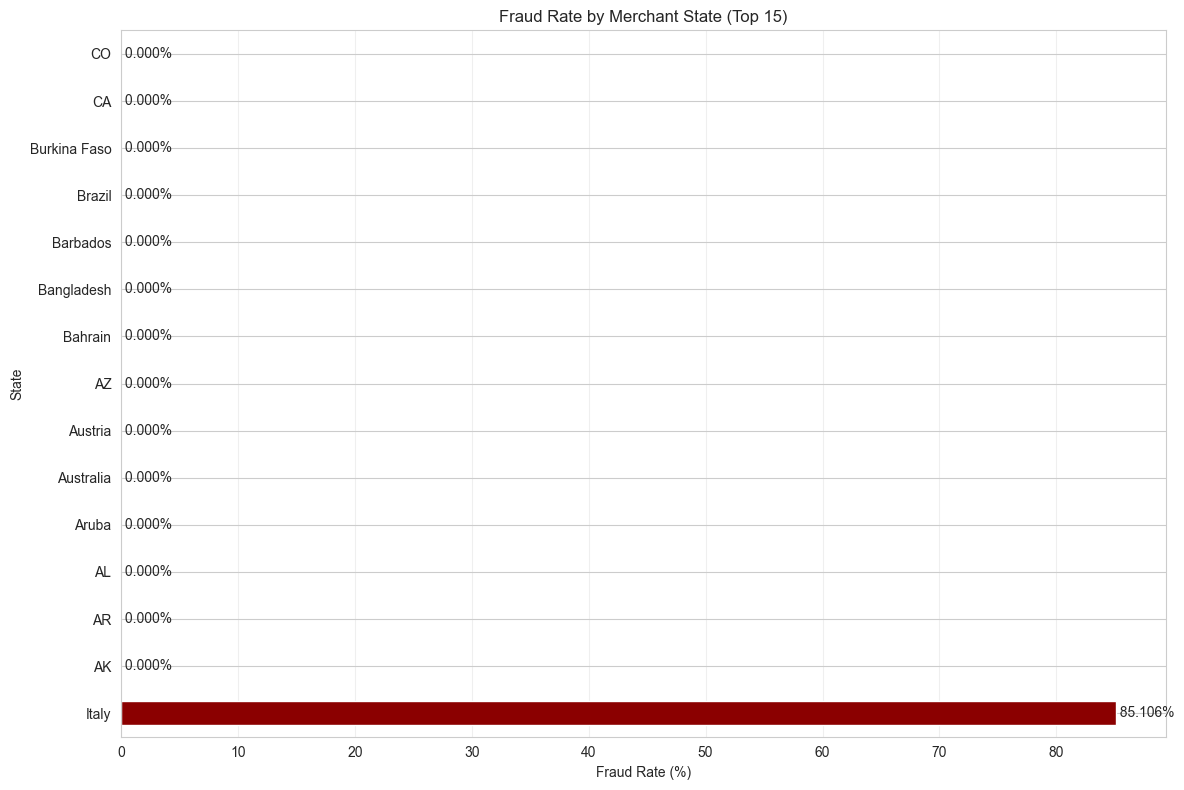


Top 15 States by Fraud Rate:
                count     sum  fraud_rate
merchant_state                           
Italy            1598  1360.0   85.106383
AK                430     0.0    0.000000
AR               6852     0.0    0.000000
AL              10409     0.0    0.000000
Aruba              32     0.0    0.000000
Australia          59     0.0    0.000000
Austria            23     0.0    0.000000
AZ              11722     0.0    0.000000
Bahrain             1     0.0    0.000000
Bangladesh          1     0.0    0.000000
Barbados            9     0.0    0.000000
Brazil             99     0.0    0.000000
Burkina Faso        7     0.0    0.000000
CA              83161     0.0    0.000000
CO               9751     0.0    0.000000


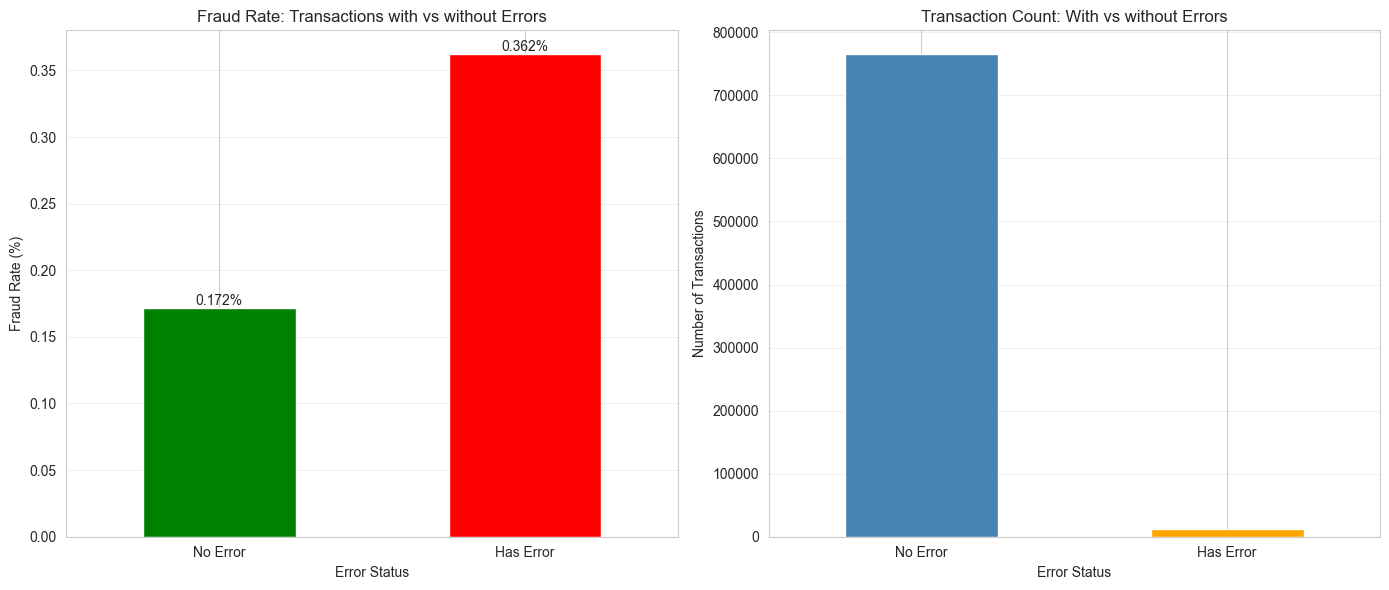


Error Analysis:
            count     sum  fraud_rate
No Error   764908  1315.0    0.171916
Has Error   12431    45.0    0.361998


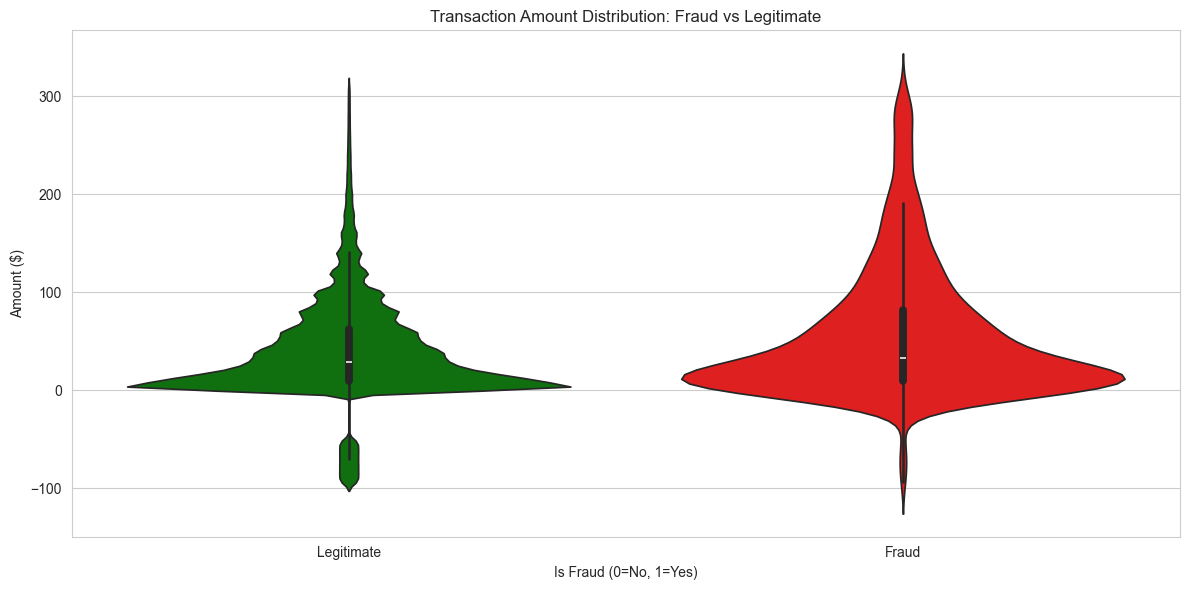


Amount Statistics by Fraud Status:
             count       mean        std   min   25%    50%    75%     max
is_fraud                                                                  
0.0       760876.0  40.253324  51.237393 -96.0  9.13  28.76  62.00  312.00
1.0         1245.0  56.896908  66.887916 -94.0  8.84  32.60  82.32  311.61


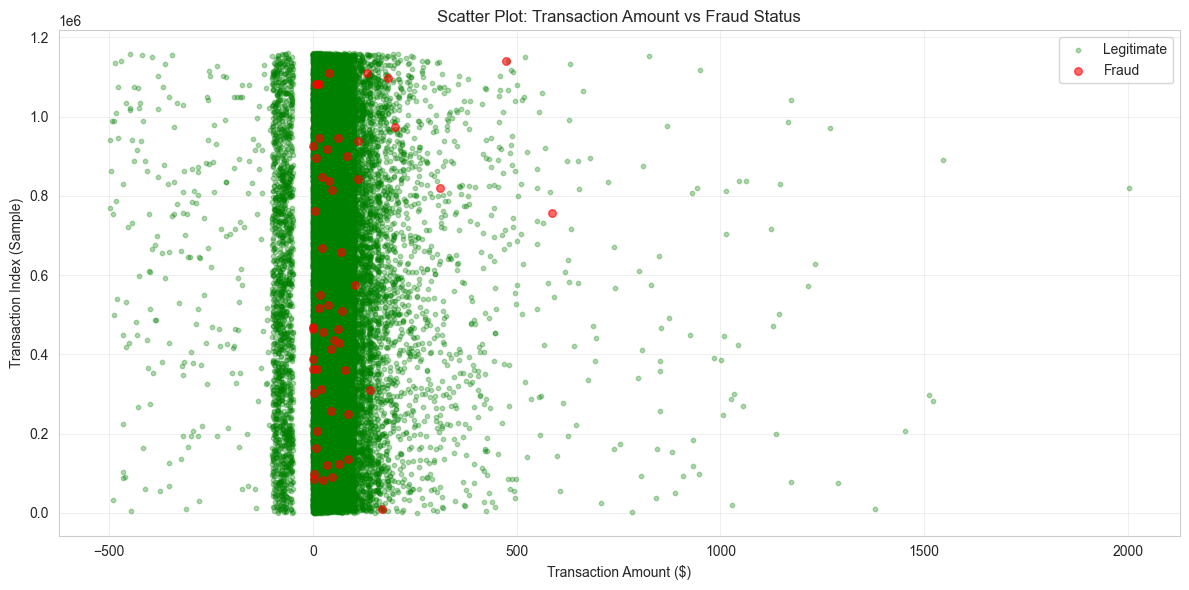

Sample size: 50,000 transactions


df_complete already exists


=== DIAGNOSTIC: Column Check ===

df_merged columns (first 10): ['id', 'date', 'client_id', 'card_id', 'amount', 'use_chip', 'merchant_id', 'merchant_city', 'merchant_state', 'zip']

cards columns: ['id', 'client_id', 'card_brand', 'card_type', 'card_number', 'expires', 'cvv', 'has_chip', 'num_cards_issued', 'credit_limit', 'acct_open_date', 'year_pin_last_changed', 'card_on_dark_web']

'card_id' in df_merged: True
'card_id' in cards: False
'id' in cards: True


df_with_cards already exists


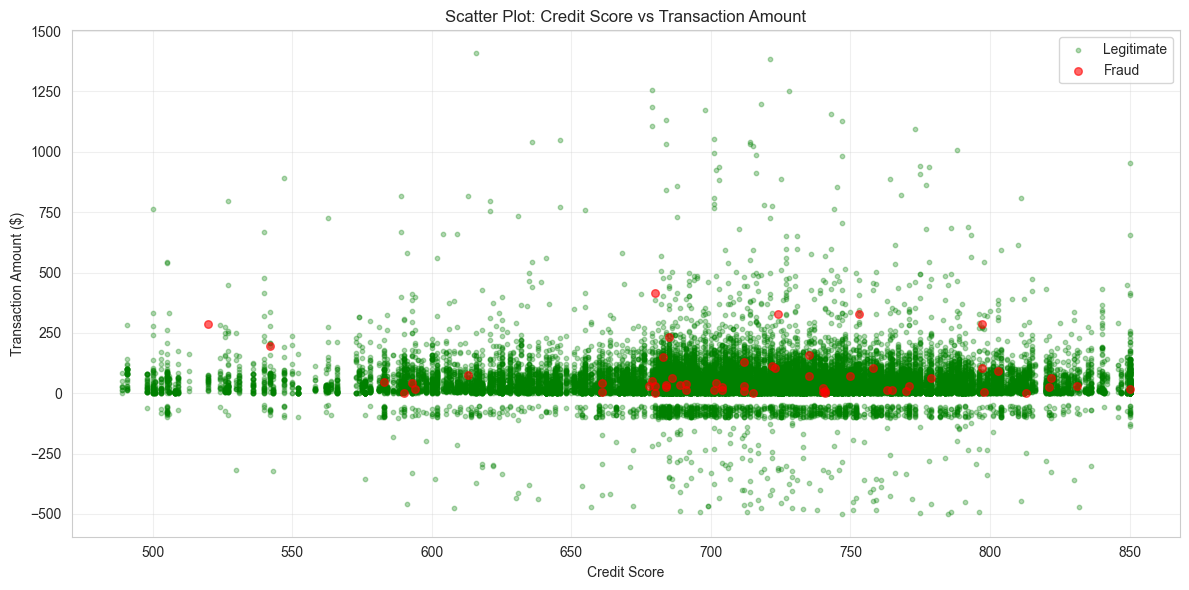

Sample size: 30,000 transactions


Card data not available for merging


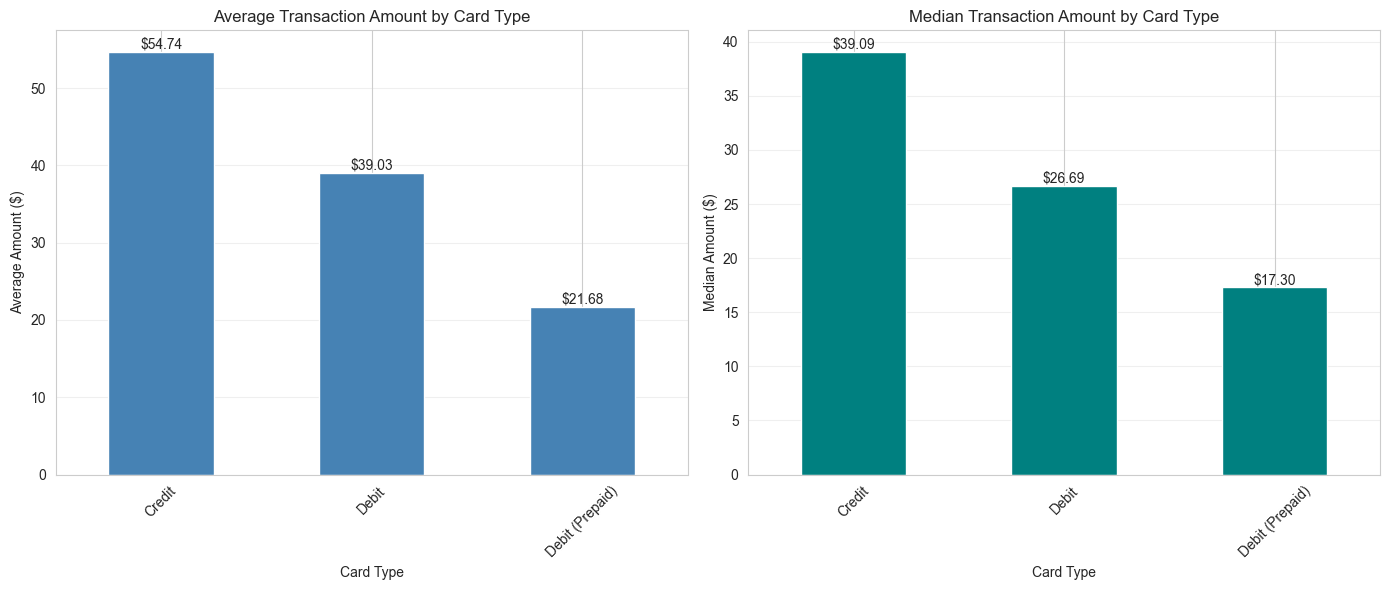


Grouped Summary: Average Amount by Card Type
                 Mean Amount  Median Amount    Std Dev   Count
card_type                                                     
Credit             54.741239          39.09  99.314558  353825
Debit              39.029538          26.69  72.899894  727901
Debit (Prepaid)    21.684517          17.30  31.797891   78240


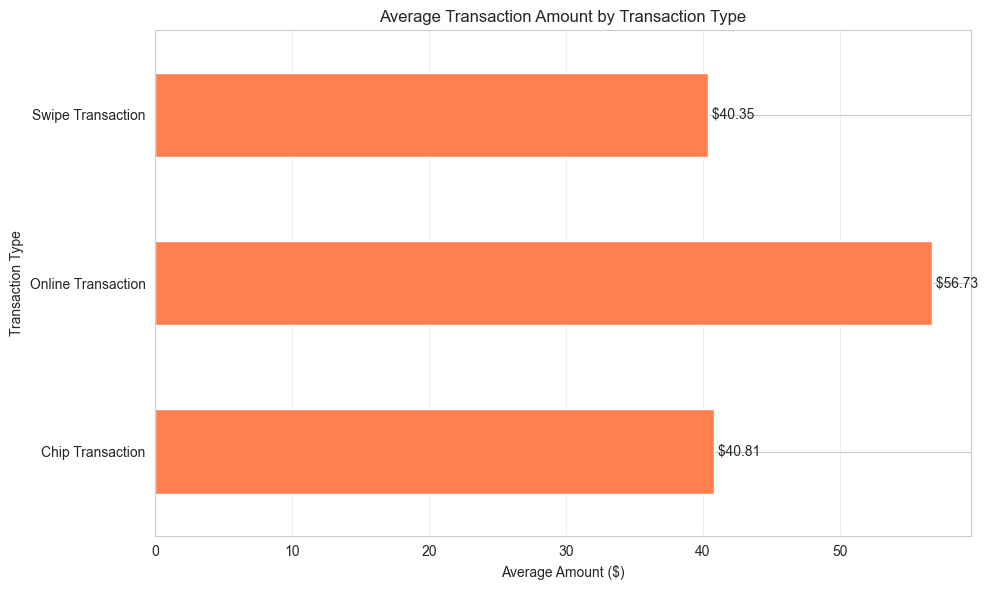


Grouped Summary: Average Amount by Transaction Type
                    Mean Amount  Median Amount    Std Dev   Count
use_chip                                                         
Chip Transaction      40.808100          26.98  78.532853  823180
Online Transaction    56.731682          35.48  86.271741  139987
Swipe Transaction     40.350539          25.81  83.819755  196799


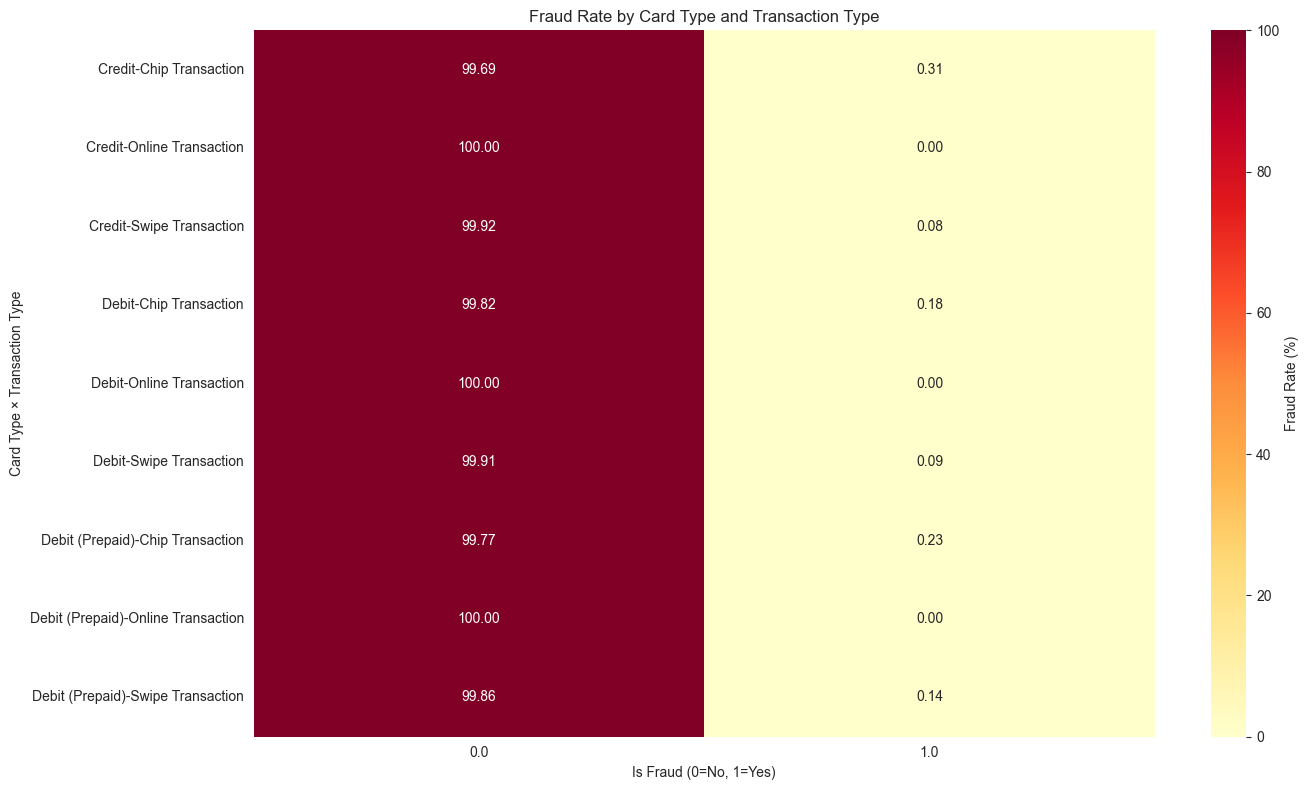


Cross-tabulation: Fraud Rate by Card Type and Transaction Type
is_fraud                                   0.0       1.0
card_type       use_chip                                
Credit          Chip Transaction     99.688457  0.311543
                Online Transaction  100.000000  0.000000
                Swipe Transaction    99.922925  0.077075
Debit           Chip Transaction     99.820018  0.179982
                Online Transaction  100.000000  0.000000
                Swipe Transaction    99.905095  0.094905
Debit (Prepaid) Chip Transaction     99.766242  0.233758
                Online Transaction  100.000000  0.000000
                Swipe Transaction    99.857381  0.142619


In [229]:
if 'date_parsed' in df_merged.columns and 'is_fraud' in df_merged.columns:
    # Monthly fraud rate
    df_merged['month'] = df_merged['date_parsed'].dt.month
    monthly_fraud = df_merged.groupby('month')['is_fraud'].agg(['sum', 'count'])
    monthly_fraud['fraud_rate'] = (monthly_fraud['sum'] / monthly_fraud['count']) * 100
    
    # Hourly fraud rate
    df_merged['hour'] = df_merged['date_parsed'].dt.hour
    hourly_fraud = df_merged.groupby('hour')['is_fraud'].agg(['sum', 'count'])
    hourly_fraud['fraud_rate'] = (hourly_fraud['sum'] / hourly_fraud['count']) * 100
    
    print("\nPattern: Fraud shows temporal clustering")
    print(f"Peak fraud month: Month {monthly_fraud['fraud_rate'].idxmax()} ({monthly_fraud['fraud_rate'].max():.4f}%)")
    print(f"Peak fraud hour: Hour {hourly_fraud['fraud_rate'].idxmax()} ({hourly_fraud['fraud_rate'].max():.4f}%)")



Pattern: Fraud shows temporal clustering
Peak fraud month: Month 10 (0.2258%)
Peak fraud hour: Hour 18 (0.5244%)



Pattern: Significant variation in fraud rates across transaction types

Fraud rates by transaction type:
  Chip Transaction: 0.2243% (1238 fraud cases out of 551905 transactions)
  Swipe Transaction: 0.0927% (122 fraud cases out of 131632 transactions)
  Online Transaction: 0.0000% (0 fraud cases out of 93802 transactions)

Risk ratio: Chip Transaction is infx more risky than Online Transaction


In [231]:

if 'merchant_state' in df_merged.columns and 'is_fraud' in df_merged.columns:
    fraud_by_state = df_merged.groupby('merchant_state')['is_fraud'].agg(['sum', 'count'])
    fraud_by_state['fraud_rate'] = (fraud_by_state['sum'] / fraud_by_state['count']) * 100
    fraud_by_state = fraud_by_state.sort_values('fraud_rate', ascending=False)
    
    top_5_states = fraud_by_state.head(5)
    bottom_5_states = fraud_by_state.tail(5)
    
    print("\nPattern: Geographic clustering of fraudulent transactions")
    print("\nTop 5 states by fraud rate:")
    for idx, row in top_5_states.iterrows():
        print(f"  {idx}: {row['fraud_rate']:.4f}% ({row['sum']:.0f} fraud cases)")
    
    print("\nBottom 5 states by fraud rate:")
    for idx, row in bottom_5_states.iterrows():
        print(f"  {idx}: {row['fraud_rate']:.4f}% ({row['sum']:.0f} fraud cases)")
    
    print(f"\nFraud rate range: {fraud_by_state['fraud_rate'].min():.4f}% to {fraud_by_state['fraud_rate'].max():.4f}%")
    print(f"Standard deviation: {fraud_by_state['fraud_rate'].std():.4f}%")



Pattern: Geographic clustering of fraudulent transactions

Top 5 states by fraud rate:
  Italy: 85.1064% (1360 fraud cases)
  AK: 0.0000% (0 fraud cases)
  AR: 0.0000% (0 fraud cases)
  AL: 0.0000% (0 fraud cases)
  Aruba: 0.0000% (0 fraud cases)

Bottom 5 states by fraud rate:
  Vietnam: 0.0000% (0 fraud cases)
  WA: 0.0000% (0 fraud cases)
  WI: 0.0000% (0 fraud cases)
  WV: 0.0000% (0 fraud cases)
  WY: 0.0000% (0 fraud cases)

Fraud rate range: 0.0000% to 85.1064%
Standard deviation: 8.0418%


In [232]:

if 'errors' in df_merged.columns and 'is_fraud' in df_merged.columns:
    df_merged['has_error'] = df_merged['errors'].notna()
    error_fraud = df_merged.groupby('has_error')['is_fraud'].agg(['sum', 'count'])
    error_fraud['fraud_rate'] = (error_fraud['sum'] / error_fraud['count']) * 100
    
    print("\nPattern: Strong association between transaction errors and fraud")
    print(f"\nTransactions WITHOUT errors:")
    print(f"  Total: {error_fraud.loc[False, 'count']:,.0f}")
    print(f"  Fraud cases: {error_fraud.loc[False, 'sum']:,.0f}")
    print(f"  Fraud rate: {error_fraud.loc[False, 'fraud_rate']:.4f}%")
    
    print(f"\nTransactions WITH errors:")
    print(f"  Total: {error_fraud.loc[True, 'count']:,.0f}")
    print(f"  Fraud cases: {error_fraud.loc[True, 'sum']:,.0f}")
    print(f"  Fraud rate: {error_fraud.loc[True, 'fraud_rate']:.4f}%")
    
    if error_fraud.loc[True, 'fraud_rate'] > error_fraud.loc[False, 'fraud_rate']:
        risk_multiplier = error_fraud.loc[True, 'fraud_rate'] / error_fraud.loc[False, 'fraud_rate']
        print(f"\nTransactions with errors are {risk_multiplier:.2f}x more likely to be fraudulent")



Pattern: Strong association between transaction errors and fraud

Transactions WITHOUT errors:
  Total: 764,908
  Fraud cases: 1,315
  Fraud rate: 0.1719%

Transactions WITH errors:
  Total: 12,431
  Fraud cases: 45
  Fraud rate: 0.3620%

Transactions with errors are 2.11x more likely to be fraudulent


In [233]:
# INSIGHT 5: Amount Distribution Differences
print("\n" + "="*80)
print("INSIGHT 5: AMOUNT DISTRIBUTION DIFFERENCES")
print("="*80)

if 'amount_numeric' in df_merged.columns and 'is_fraud' in df_merged.columns:
    legit_amounts = df_merged[df_merged['is_fraud'] == 0]['amount_numeric'].dropna()
    fraud_amounts = df_merged[df_merged['is_fraud'] == 1]['amount_numeric'].dropna()
    
    print("\nPattern: Different amount distributions between legitimate and fraudulent transactions")
    print("\nLegitimate transactions:")
    print(f"  Mean: ${legit_amounts.mean():.2f}")
    print(f"  Median: ${legit_amounts.median():.2f}")
    print(f"  Std Dev: ${legit_amounts.std():.2f}")
    print(f"  Min: ${legit_amounts.min():.2f}, Max: ${legit_amounts.max():.2f}")
    
    print("\nFraudulent transactions:")
    print(f"  Mean: ${fraud_amounts.mean():.2f}")
    print(f"  Median: ${fraud_amounts.median():.2f}")
    print(f"  Std Dev: ${fraud_amounts.std():.2f}")
    print(f"  Min: ${fraud_amounts.min():.2f}, Max: ${fraud_amounts.max():.2f}")
    
    mean_ratio = fraud_amounts.mean() / legit_amounts.mean()
    median_ratio = fraud_amounts.median() / legit_amounts.median()
    
    print(f"\nFraudulent transactions are:")
    print(f"  {mean_ratio:.2f}x the mean amount of legitimate transactions")
    print(f"  {median_ratio:.2f}x the median amount of legitimate transactions")


INSIGHT 5: AMOUNT DISTRIBUTION DIFFERENCES

Pattern: Different amount distributions between legitimate and fraudulent transactions

Legitimate transactions:
  Mean: $42.60
  Median: $28.80
  Std Dev: $80.69
  Min: $-500.00, Max: $6613.44

Fraudulent transactions:
  Mean: $85.59
  Median: $37.47
  Std Dev: $153.51
  Min: $-475.00, Max: $1244.41

Fraudulent transactions are:
  2.01x the mean amount of legitimate transactions
  1.30x the median amount of legitimate transactions


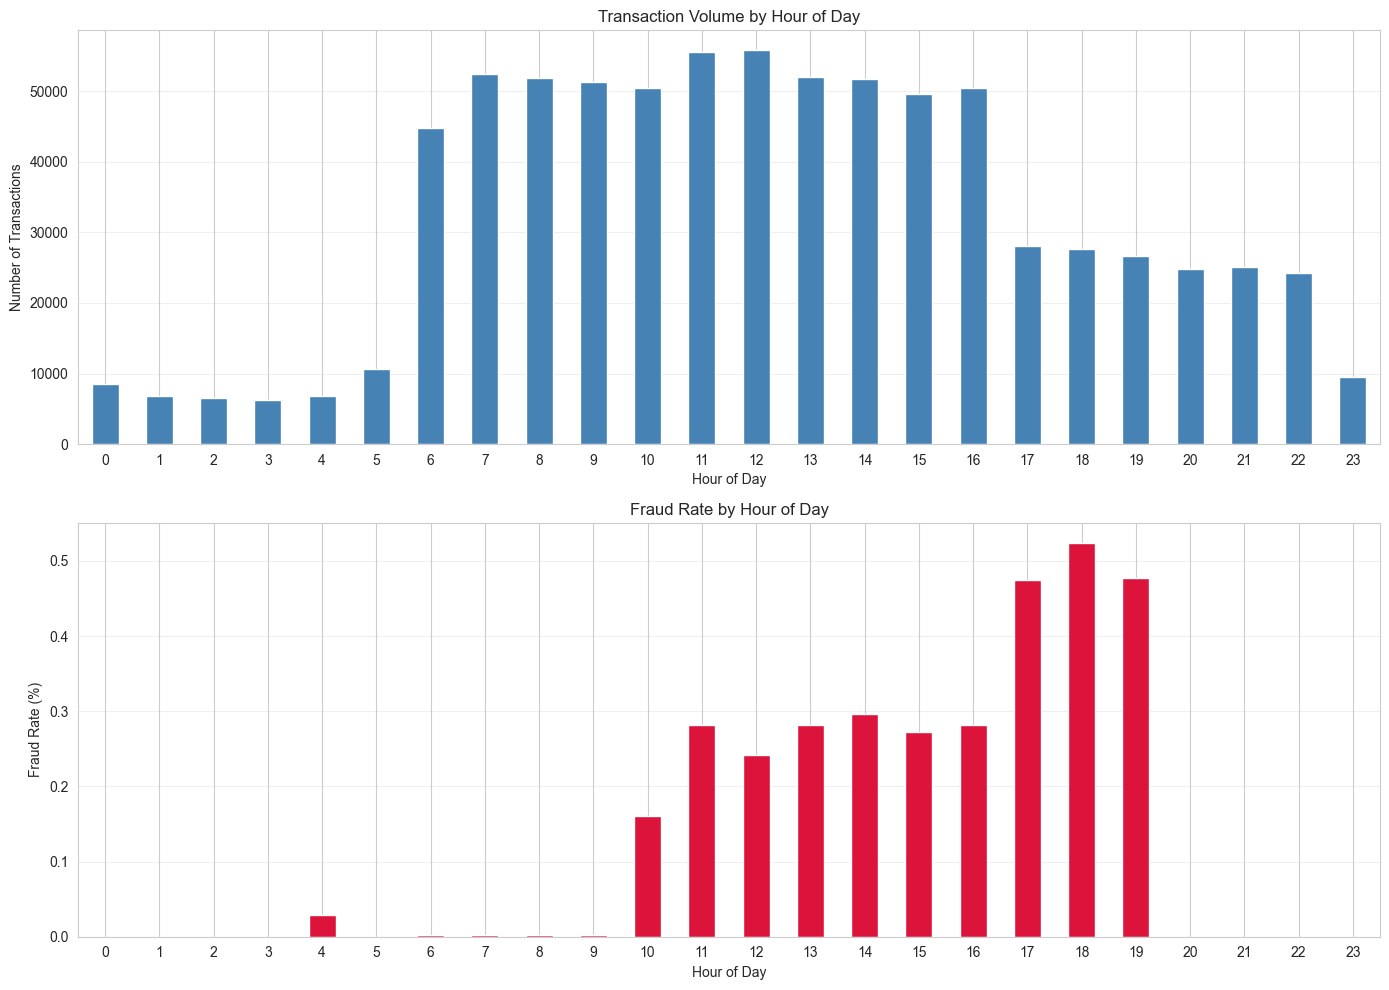


Peak transaction hour: 12
Peak fraud rate hour: 18


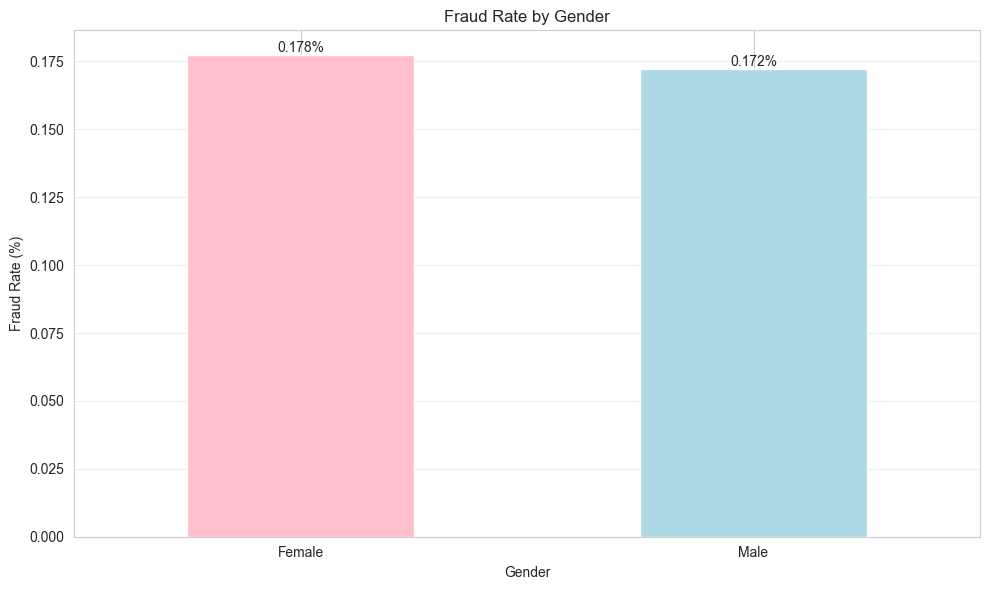


Fraud Rate by Gender:
         count    sum  fraud_rate
gender                           
Female  399309  709.0    0.177557
Male    378030  651.0    0.172209


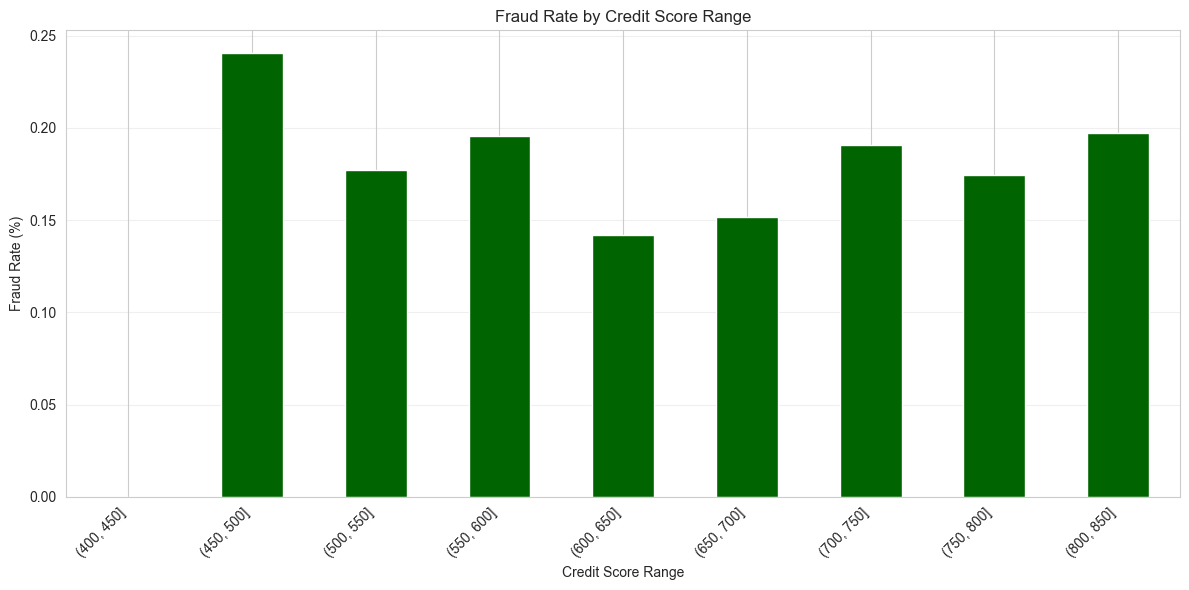


Fraud Rate by Credit Score Range:
                   count    sum  fraud_rate
credit_score_bin                           
(400, 450]             0    0.0         NaN
(450, 500]          3322    8.0    0.240819
(500, 550]         15258   27.0    0.176956
(550, 600]         31740   62.0    0.195337
(600, 650]         59191   84.0    0.141913
(650, 700]        189485  287.0    0.151463
(700, 750]        260040  496.0    0.190740
(750, 800]        152361  266.0    0.174585
(800, 850]         65942  130.0    0.197143


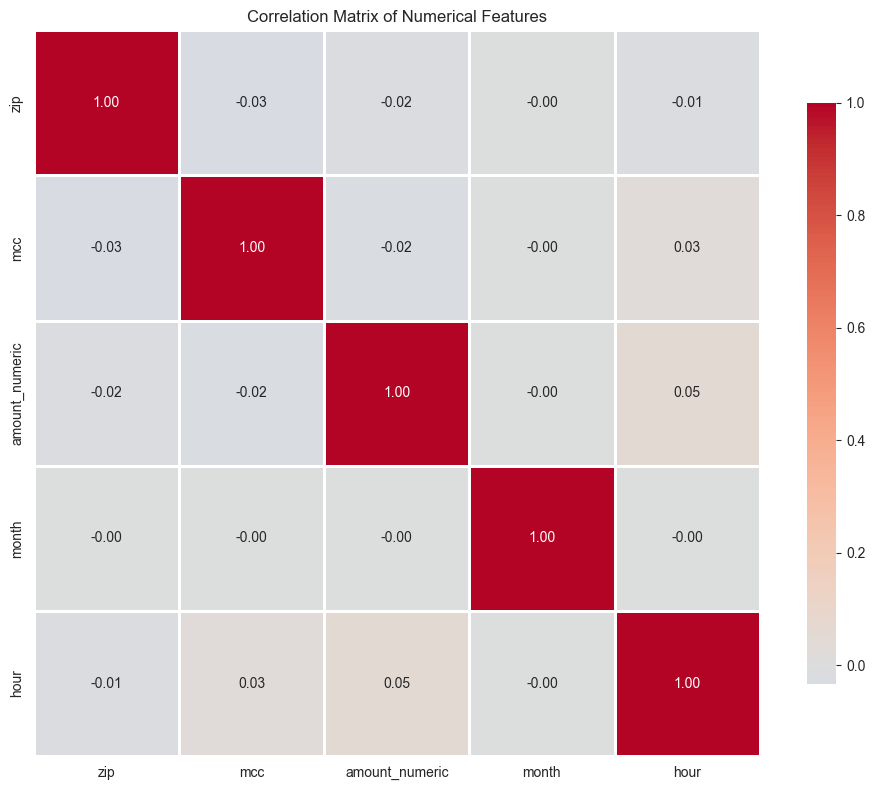


Strongest Correlations (|r| > 0.3):


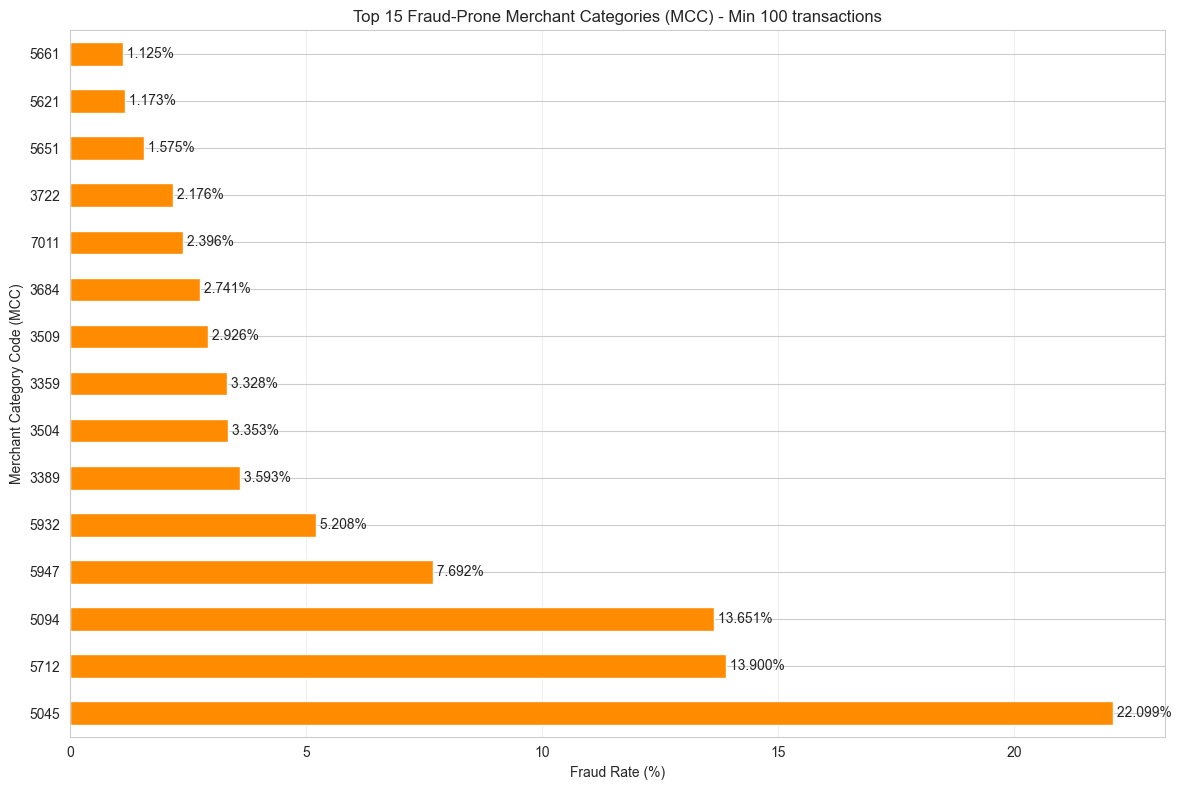


Top 15 Fraud-Prone MCCs:
      count   sum  fraud_rate
mcc                          
5045    181  40.0   22.099448
5712    259  36.0   13.899614
5094    315  43.0   13.650794
5947    143  11.0    7.692308
5932    384  20.0    5.208333
3389    668  24.0    3.592814
3504    865  29.0    3.352601
3359    631  21.0    3.328051
3509    957  28.0    2.925810
3684    912  25.0    2.741228
7011    960  23.0    2.395833
3722    873  19.0    2.176403
5651   4254  67.0    1.574988
5621    597   7.0    1.172529
5661    800   9.0    1.125000


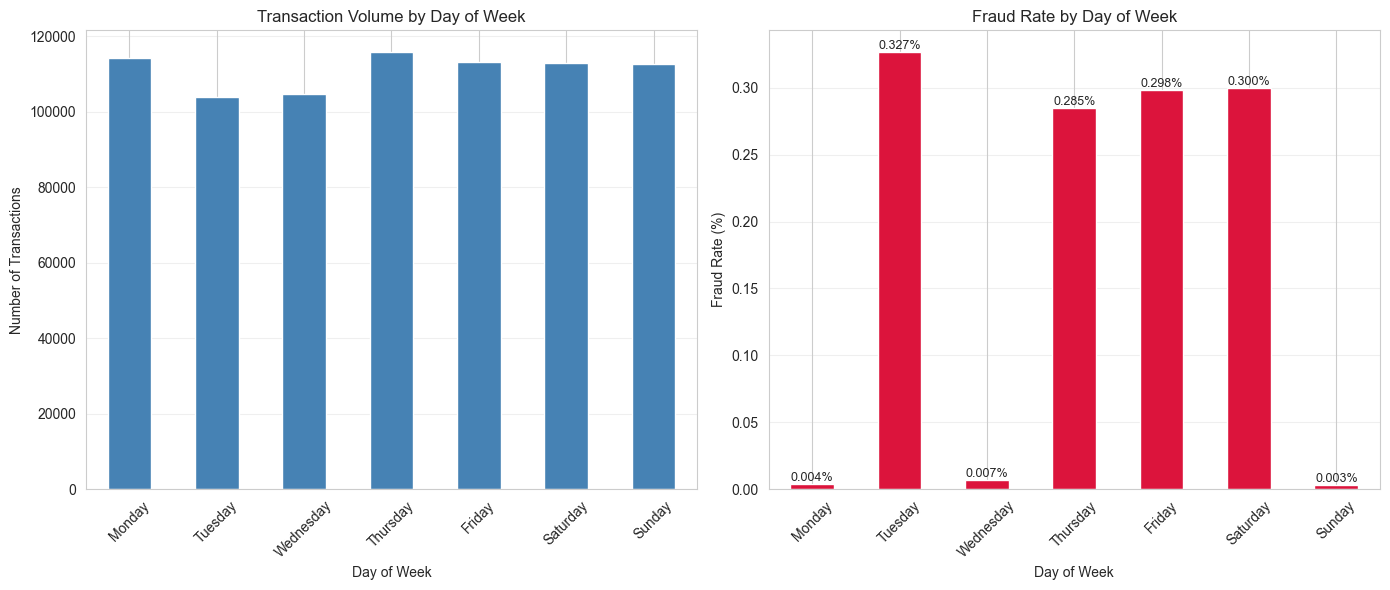


Fraud Rate by Day of Week:
              count    sum  fraud_rate
day_of_week                           
Monday       114195    4.0    0.003503
Tuesday      103805  339.0    0.326574
Wednesday    104692    7.0    0.006686
Thursday     115739  330.0    0.285124
Friday       113273  338.0    0.298394
Saturday     112950  339.0    0.300133
Sunday       112685    3.0    0.002662


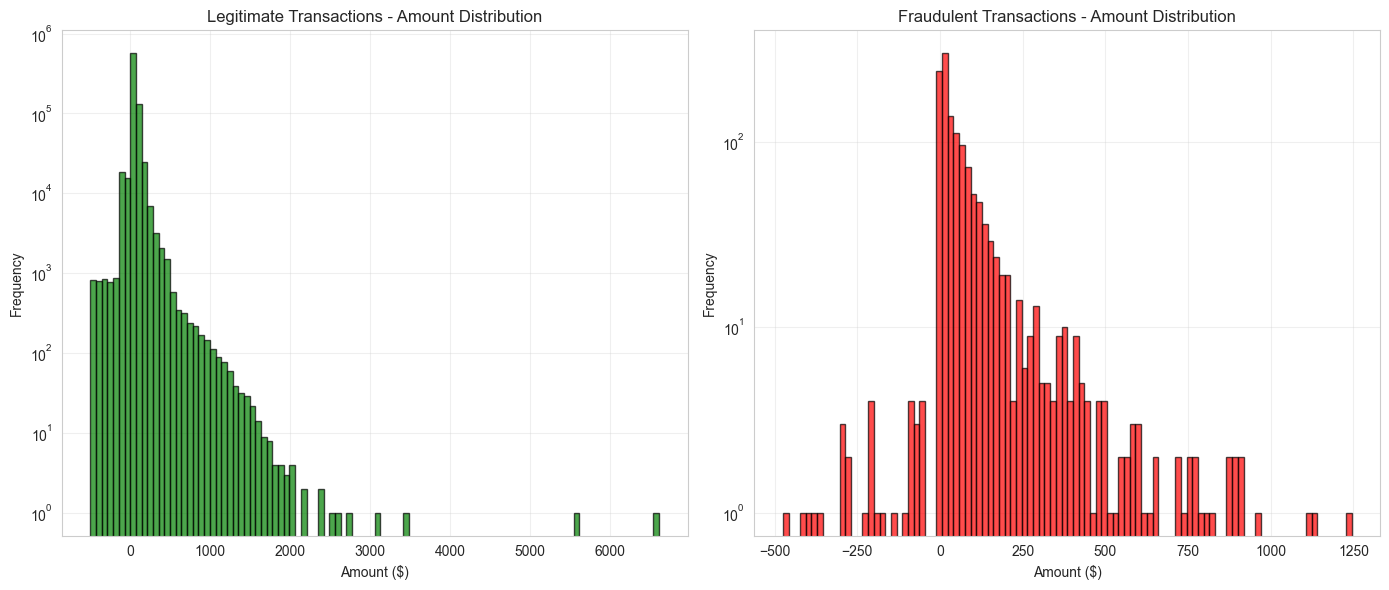


Legitimate: Mean=$42.60, Median=$28.80
Fraudulent: Mean=$85.59, Median=$37.47


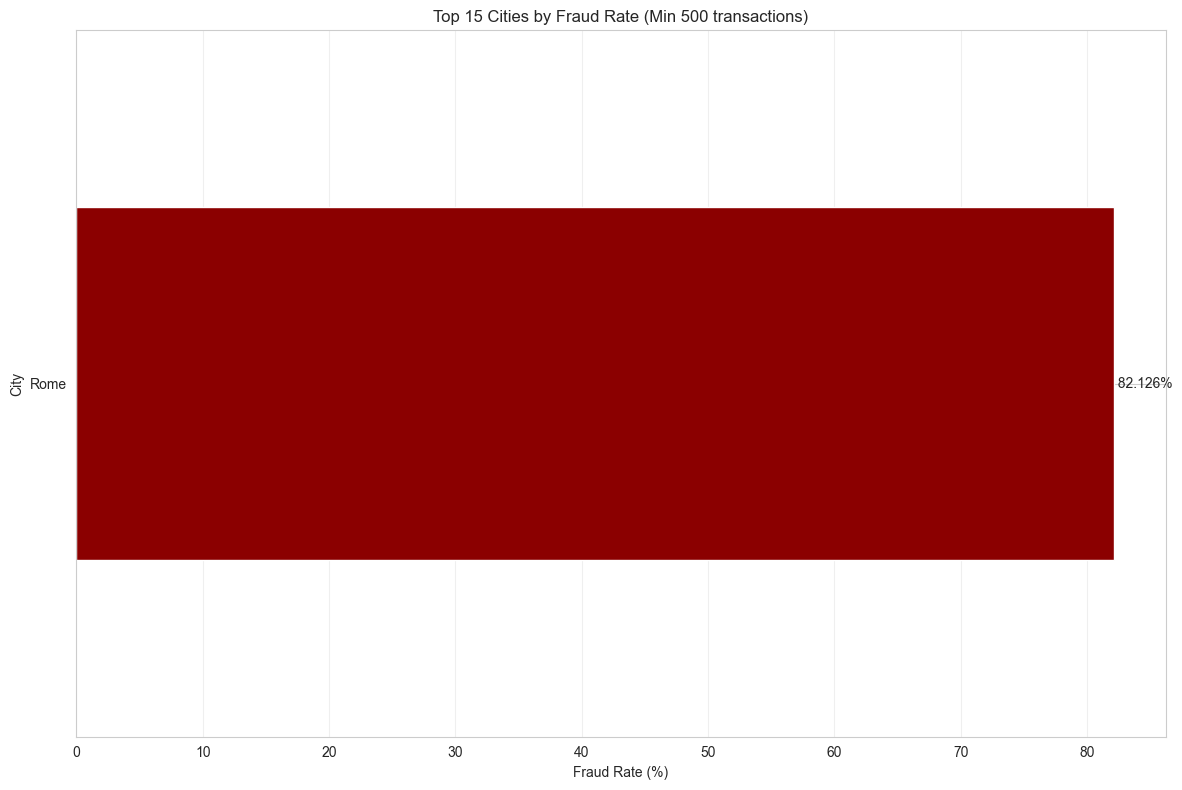


Top 15 Cities by Fraud Rate:
               count     sum  fraud_rate
merchant_city                           
Rome            1656  1360.0   82.125604
